# Load stuff

In [1]:
import pandas as pd
import nltk
from nltk.stem import WordNetLemmatizer
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from textblob import TextBlob
from wordcloud import WordCloud, ImageColorGenerator
# nltk.download('punkt')
# nltk.download('words')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

%matplotlib inline
%config InlineBackend.figure_format ='retina'

In [2]:
def lin_reg(x, y):
    A = np.vstack((x, np.ones_like(x))).T
    m, b = np.linalg.lstsq(A, Y, rcond=None)[0]
    
    return m, b

# Load dataset

## GBB ratings

In [3]:
dataBig = pd.read_csv('dataset/bgg-19m-reviews.csv')
print(len(dataBig), "rows")

18964807 rows


In [4]:
#Only ratings with comments
dataValid = dataBig[pd.notna(dataBig['comment'])]
print(len(dataValid), "rows with comments")

3368619 rows with comments


In [5]:
data = dataValid

## Coursera reviews

In [80]:
data = pd.read_csv('dataset/coursera reviews.csv')
print(len(data), "rows")

107018 rows


In [81]:
data = pd.DataFrame({
    'comment': data['Review'],
    'rating': data['Label']
})

In [82]:
#Ratings should be -1 to 1
data['rating'] = data['rating'] / 2 - 1.5

# Dataset Statistics

In [7]:
data

,Unnamed: 0,user,rating,comment,ID,name
1,1,mitnachtKAUBO-I,10.0,Hands down my favorite new game of BGG CON 200...,30549,Pandemic
2,2,avlawn,10.0,I tend to either love or easily tire of co-op ...,30549,Pandemic
4,4,Mease19,10.0,This is an amazing co-op game. I play mostly ...,30549,Pandemic
5,5,cfarrell,10.0,Hey! I can finally rate this game I've been pl...,30549,Pandemic
8,8,gregd,10.0,Love it- great fun with my son. 2 plays so far...,30549,Pandemic
...,...,...,...,...,...,...
18964798,18964798,Peter The Rat,4.0,"Sadly, to slow moving and fiddly!",1752,Haps
18964800,18964800,spellengek,4.0,"Weird card game with some nice gameplay, but a...",1752,Haps
18964803,18964803,Gregarius,2.0,"I hated this game. Too complicated to set up, ...",1752,Haps
18964804,18964804,Lajos,2.0,Sold in Geekauction for 3 GG.,1752,Haps


In [8]:
#Avg char count
data['comment'].apply(len).mean()

211.05346196764907

In [9]:
#Avg word count
data['comment'].apply(lambda c: len(c.split())).mean()

37.68614527199425

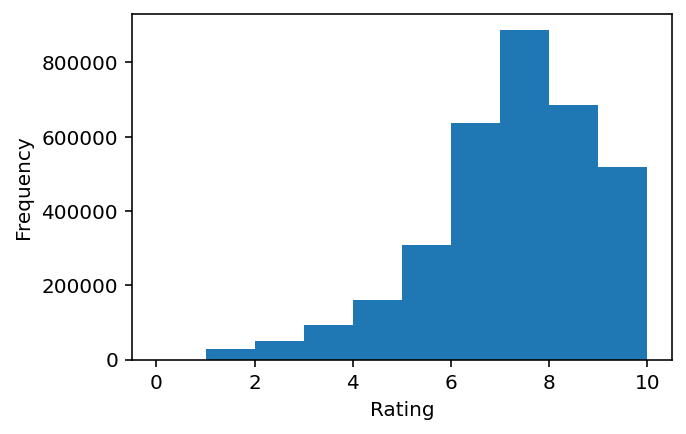

In [10]:
ax = (data['rating']).plot.hist(bins=10, xlabel='rating', figsize=(5, 3))
ax.set_xlabel("Rating");
plt.subplots_adjust(top = 0.95, bottom = 0.15, right = 0.95, left = 0.2)
plt.savefig("rating_hist.pdf")

# Average rating lexicon

In [11]:
#Downsample for speed if needed
# data = data.sample(10_000)
#Rescale if needed
data['ratingResale'] = data['rating'] / 5 - 1

/tmp/ipykernel_3368475/1210366783.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ratingResale'] = data['rating'] / 5 - 1


In [12]:
#Only include english non-stopwords, lemmatize, and lowercase
validWords = set(w.lower() for w in nltk.corpus.words.words())
stopWords = set(w.lower() for w in nltk.corpus.stopwords.words())
validWords -= stopWords
lemmatizer = WordNetLemmatizer()

def toWords(text):
    words = nltk.word_tokenize(text)
    words = [lemmatizer.lemmatize(w) for w in words]
    words = [w.lower() for w in words]
    return tuple(words)

print(toWords("Hello worlds! I am a person"))

('hello', 'world', '!', 'i', 'am', 'a', 'person')


In [13]:
len(validWords)

233431

In [14]:
#Split comment to words
words = []
for i, c in enumerate(data['comment']):
    words.append(toWords(c))
    if i % 5000 == 0:
        print(i)

data['words'] = words

0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
100000
105000
110000
115000
120000
125000
130000
135000
140000
145000
150000
155000
160000
165000
170000
175000
180000
185000
190000
195000
200000
205000
210000
215000
220000
225000
230000
235000
240000
245000
250000
255000
260000
265000
270000
275000
280000
285000
290000
295000
300000
305000
310000
315000
320000
325000
330000
335000
340000
345000
350000
355000
360000
365000
370000
375000
380000
385000
390000
395000
400000
405000
410000
415000
420000
425000
430000
435000
440000
445000
450000
455000
460000
465000
470000
475000
480000
485000
490000
495000
500000
505000
510000
515000
520000
525000
530000
535000
540000
545000
550000
555000
560000
565000
570000
575000
580000
585000
590000
595000
600000
605000
610000
615000
620000
625000
630000
635000
640000
645000
650000
655000
660000
665000
670000
675000
680000
685000
690000
695000
700000
705000
710000
715000
720000
725000
730

/tmp/ipykernel_3368475/1027488787.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['words'] = words


In [15]:
#Only keep words that appear in 100 or more comments and are in validWords
wordCounts = {}

for i, row in data.iterrows():
    for word in set(row["words"]):
        wordCounts[word] = wordCounts.get(word, 0) + 1
    if i % 10000 == 0:
        print(i)

dictionary = {w for w in validWords if wordCounts.get(w, 0) >= 1000}

data["words"] = data['words'].apply(lambda ws: tuple(w for w in ws if w in dictionary))

30000
40000
50000
60000
80000
90000
100000
180000
210000
240000
320000
340000
470000
540000
620000
700000
730000
740000
790000
820000
870000
910000
1040000
1050000
1060000
1240000
1280000
1420000
1430000
1520000
1720000
1860000
1920000
1930000
2150000
2160000
2190000
2220000
2360000
2370000
2380000
2400000
2420000
2500000
2510000
2530000
2760000
2820000
2860000
2890000
3070000
3120000
3170000
3200000
3320000
3420000
3690000
3720000
3770000
3840000
3910000
3930000
4040000
4110000
4220000
4240000
4260000
4280000
4290000
4310000
4360000
4620000
4640000
4660000
4670000
4690000
4720000
4730000
4810000
4840000
4860000
4980000
5060000
5070000
5130000
5220000
5250000
5270000
5340000
5350000
5380000
5420000
5520000
5600000
5650000
5690000
5700000
5860000
5920000
6010000
6250000
6280000
6310000
6330000
6380000
6400000
6410000
6690000
6720000
6740000
6770000
6830000
6910000
7150000
7260000
7410000
7460000
7480000
7550000
7560000
7580000
7620000
7640000
7650000
7830000
7930000
7970000
8020000
8050

/tmp/ipykernel_3368475/3383742928.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["words"] = data['words'].apply(lambda ws: tuple(w for w in ws if w in dictionary))


In [16]:
data[['rating', 'words']]

,rating,words
1,10.0,"(favorite, game, time, row, pandemic, store, j..."
2,10.0,"(tend, love, easily, tire, game, pandemic, joi..."
4,10.0,"(amazing, game, play, wife, game, imagine, tir..."
5,10.0,"(hey, finally, rate, game, couple, year, pande..."
8,10.0,"(love, great, fun, play, forward)"
...,...,...
18964798,4.0,"(sadly, slow, moving)"
18964800,4.0,"(weird, card, game, nice, problem, game, find,..."
18964803,2.0,"(game, complicated, set, boring, continue)"
18964804,2.0,"(sold,)"


In [17]:
#Compute score as avg rating
wordRatings = {w: [] for w in dictionary}

for i, row in data.iterrows():
    for word in row["words"]:
        wordRatings[word].append(row['rating'])

In [18]:
wordScores = {w: np.mean(r) for w, r in wordRatings.items()}
wordWeights = {w: 1 for w, r in wordRatings.items()}

In [19]:
def predict(words):
    #predict rating by averaging score
    # words = [w for w in words if w in dictionairy]
    if len(words) == 0:
        return np.nan
    words = words[:]
    return np.sum([wordScores[w] * wordWeights[w] for w in words]) / np.sum([wordWeights[w] for w in words])

# Gradient descent to optimize scores

In [165]:
lossList = []

#((r1, (w11, w12, ...)), (r2, (w21, w22, ...))) where all w are in dictionairy
#    to make code faster
dataObj = tuple((row['rating'], tuple(w for w in row['words'] if w in dictionairy)) for _, row in data.iterrows())
dataObj = tuple((r, ws) for r, ws in dataObj if len(ws))

def err():
    return sum((r - predict(ws))**2 for r, ws in dataObj) / len(dataObj)

print(err())

2.939259941609651


1 2.664677953566744
2 2.6641004610407424
3 2.6635312517110696
4 2.662952552910467
5 2.6623873537900886
6 2.6618395196096656
7 2.661303392934403
8 2.660780160967035
9 2.660266467671693
10 2.659755282431941
11 2.6592561753506296
12 2.658758251072906
13 2.658267866737934
14 2.6577890726370597
15 2.657316672598852
16 2.6568515068814538
17 2.656385628358871
18 2.655915995952324
19 2.6554561753467483
20 2.655005569357044


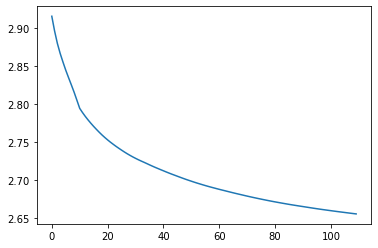

In [175]:
lrS = 2e-4
lrW = 3e-5

for n in range(20):
    scoreGrad = {w: 0 for w in dictionairy}
    weightGrad = {w: 0 for w in dictionairy}

    for rating, words in dataObj:
        Rhat = predict(words)
        dEdRhat = -2 * (rating - Rhat)
        wSum = sum(wordWeights[w] for w in words)
        for word in words:
            scoreGrad[word] += dEdRhat * wordWeights[word] / wSum
            weightGrad[word] += dEdRhat * (wSum * wordScores[word] - wordWeights[word] * wordScores[word]) / wSum**2

    for w, g in scoreGrad.items():
        wordScores[w] -= lrS * g
        
    for w, g in weightGrad.items():
        wordWeights[w] -= lrW * g
        wordWeights[w] = max(min(wordWeights[w], 3), 0.3)

    loss = err()
    lossList.append(loss)
    print(n + 1, loss)

plt.plot(lossList);

# Using Sentence Transformers (BERT)

In [7]:
stModel = SentenceTransformer('all-MiniLM-L6-v2')

In [19]:
sentences = ['This framework generates embeddings for each input sentence',
    'Sentences are passed as a list of string.',
    'The quick brown fox jumps over the lazy dog.']

#Sentences are encoded by calling model.encode()
embeddings = stModel.encode(sentences)
embeddings

array([[-0.01371736, -0.04285152, -0.01562859, ...,  0.10017824,
         0.12365721, -0.04229669],
       [ 0.05645248,  0.05500238,  0.03137964, ...,  0.06650875,
         0.08491524, -0.0332849 ],
       [ 0.04393357,  0.05893441,  0.04817837, ...,  0.05216278,
         0.05610648,  0.10206395]], dtype=float32)

In [37]:
emb = stModel.encode(list(data['comment']))
emb.shape

(10000, 384)

In [44]:
A = np.vstack((emb.T, np.ones(emb.shape[0]))).T
Y = data['rating'].values.reshape(-1, 1)
res = np.linalg.lstsq(A, Y, rcond=None)[0]
pred = A @ res

In [55]:
np.mean(pred[Y==9])

7.553752749888986

0.3094857568963453


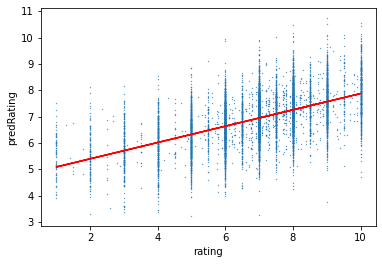

In [39]:
data['predRating'] = pred
X = data['rating'].values
Y = data['predRating'].values

data.plot.scatter(x='rating', y='predRating', s=0.1)
m, b = lin_reg(X, Y)
yPred = m * X + b
plt.plot(X, yPred, color='red')
print(m)

In [41]:
np.mean(np.abs(Y - pred))

1.096702271271996

In [104]:
testEmb = stModel.encode([
    "The game was very fun!"
])
A = np.vstack((testEmb.T, np.ones(testEmb.shape[0]))).T
float(A @ res)

8.64425936653187

# Using TextBlob

In [65]:
pred = data['comment'].apply(lambda c: TextBlob(c).sentiment.polarity * 2.0 + 6.8)
pred.mean()
np.mean(np.abs(data['rating'] - pred))

1.3517298985855695

0.05546670456393324


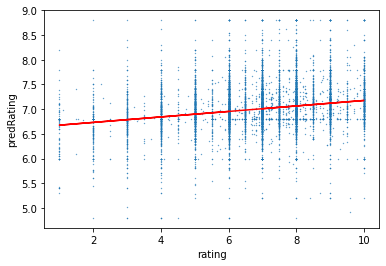

In [66]:
data['predRating'] = pred
X = data['rating'].values
Y = data['predRating'].values

data.plot.scatter(x='rating', y='predRating', s=0.1)
m, b = lin_reg(X, Y)
yPred = m * X + b
plt.plot(X, yPred, color='red')
print(m)

In [95]:
TextBlob("This is the most boring presentation ever!").sentiment

Sentiment(polarity=-0.25, subjectivity=0.75)

# Results

In [20]:
#Construct pd dataframe of words (for nice display)
words = pd.DataFrame({"word": wordScores.keys(), "score": wordScores.values(), "weights": wordWeights.values()})
words.sort_values(by='score', inplace=True)
words.reset_index(drop=True, inplace=True)
words[['word', 'score']]

,word,score
0,ugh,4.117879
1,garbage,4.447380
2,unplayable,4.584249
3,pointless,4.594815
4,boredom,4.637409
...,...,...
3228,phenomenal,8.319569
3229,excelente,8.353379
3230,addicted,8.391496
3231,masterpiece,8.727073


In [21]:
words.to_csv('words.csv', index=False)

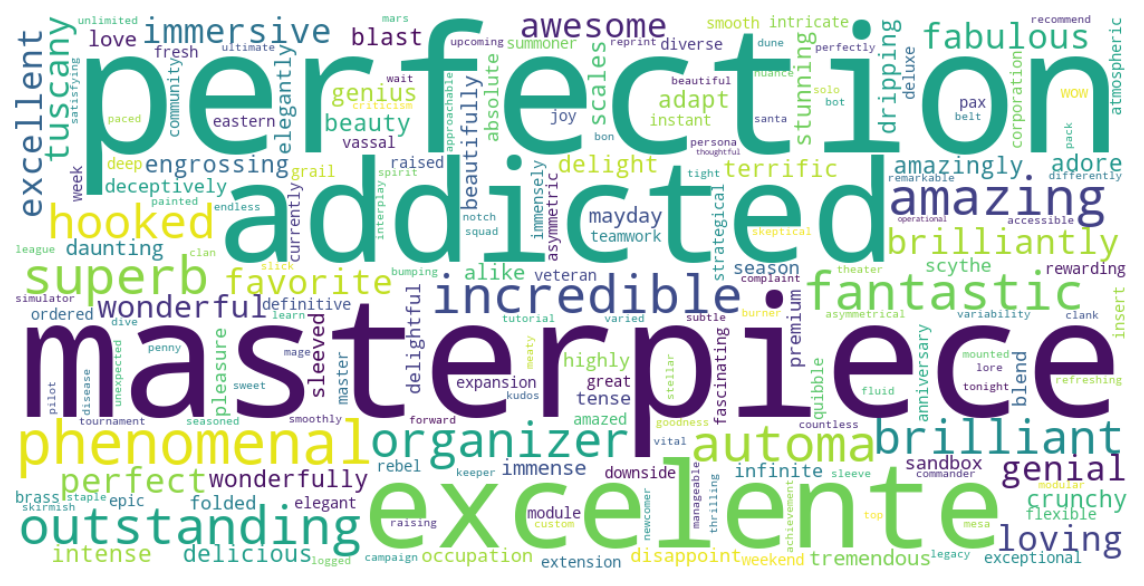

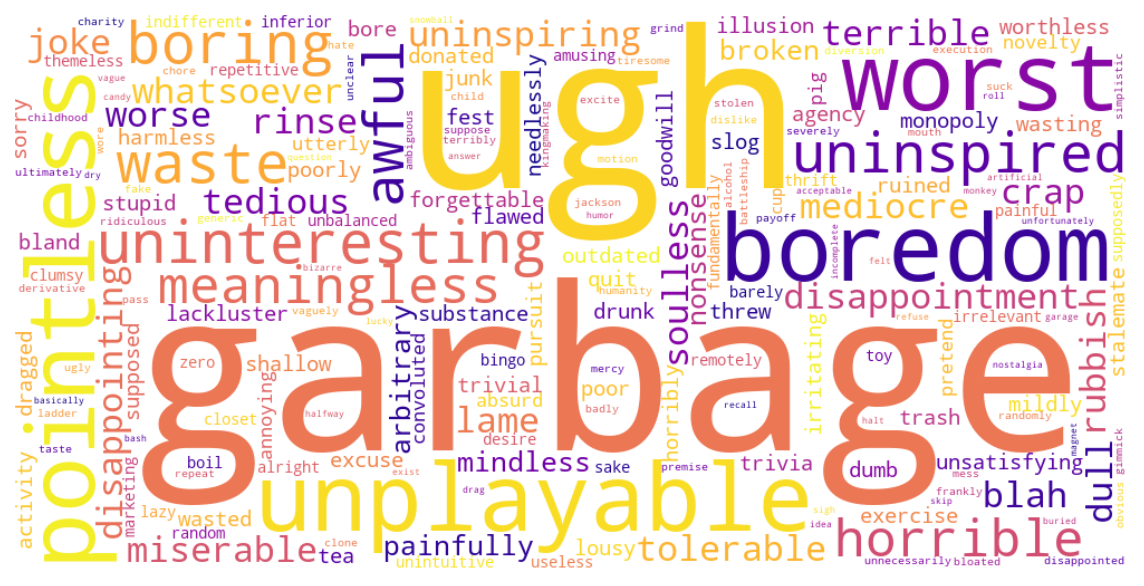

In [51]:
wordcloud = WordCloud(
    width=1000, height=500, background_color="white", colormap="viridis"
).generate_from_frequencies(
    {w: s for w, s in wordScores.items()}
    
)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig("wordcloud_pos1.pdf", bbox_inches='tight')
plt.show()

wordcloud = WordCloud(
    width=1000, height=500, background_color="white", colormap="plasma"
).generate_from_frequencies(
    {w: -s for w, s in wordScores.items()}
)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig("wordcloud_neg1.pdf", bbox_inches='tight')
plt.show()

/tmp/ipykernel_3553596/3110268297.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['predRating'] = data['words'].apply(predict)


0.060421126880688465


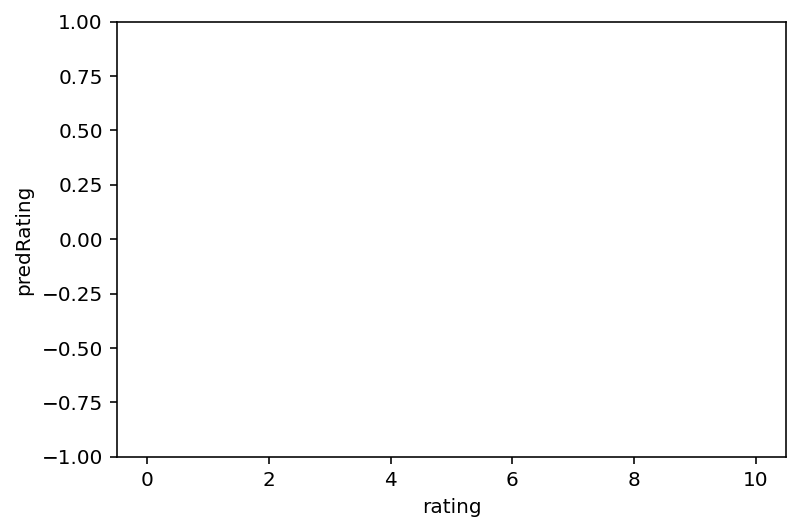

In [38]:
data['predRating'] = data['words'].apply(predict)
X = data[data['predRating'] > 0]['rating'].values
Y = data[data['predRating'] > 0]['predRating'].values

data[data['predRating'] > 0].plot.scatter(x='rating', y='predRating', s=0.1)
m, b = lin_reg(X, Y)
yPred = m * X + b
plt.plot(X, yPred, color='red')
plt.ylim(-1, 1)
print(m)

plt.savefig("predRatings_scatter.pdf")

In [35]:
s = [w for w in toWords("This is a masterpiece!") if w in dictionary]
print(s)
predict(s) / 5 - 1

['masterpiece']


0.7454145954904607